In [1]:
import argparse
import os
import sys
import pickle
import time
import subprocess
import shutil
sys.path.append(os.getcwd())

from khrylib.utils import *
from khrylib.rl.utils.visualizer import Visualizer
from khrylib.rl.core.policy_gaussian import PolicyGaussian
from khrylib.rl.core.critic import Value
from khrylib.models.mlp import MLP
from motion_imitation.envs.humanoid_im import HumanoidEnv, HumanoidEnvFreezeKnee
from motion_imitation.utils.config import Config
import matplotlib.pyplot as plt





In [11]:
cfg = Config('0202', False, create_dirs=False)
cfg_f = Config('0202_freeze', False, create_dirs=False)
cfg.env_start_first = True
cfg_f.env_start_first = True
logger = create_logger(os.path.join(cfg.log_dir, 'log_eval.txt'))

"""make and seed env"""
dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(cfg.seed)
torch.set_grad_enabled(False)
env = HumanoidEnv(cfg)
env.seed(cfg.seed)


body_qposaddr = get_body_qposaddr(env.model)
body_qposaddr_list_start_index = [idxs[0] for idxs in list(body_qposaddr.values())]
def plot_qpos(qpos, body_qposaddr_list_start_index):
    fig, axs = plt.subplots(nrows=qpos.shape[1]//4+1, ncols=4, figsize=(10, 12))
    for i in range(qpos.shape[1]//4+1):
        for j in range(4):
            idx = i*4 + j
            if idx >= qpos.shape[1]:
                break
            gt = qpos[:, idx]
            axs[i, j].plot(gt, 'r', label='gt')
            axs[i, j].set_ylim([-np.pi, np.pi])
            if idx in body_qposaddr_list_start_index:
                body_name = [name for name, addr in body_qposaddr.items() if addr[0] == idx][0]
                axs[i, j].set_title(f"idx = {idx}, {body_name}", fontsize=12)
            if i == 0 and j == 0:
                axs[i, j].legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_qpos(qpos, body_qposaddr_list_start_index )



env_f = HumanoidEnvFreezeKnee(cfg_f, cfg)
env_f.seed(cfg_f.seed)

actuators = env.model.actuator_names
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actuators_f = env_f.model.actuator_names
state_dim_f = env_f.observation_space.shape[0]
action_dim_f = env_f.action_space.shape[0]

"""load learner policy"""
policy_net = PolicyGaussian(MLP(state_dim, cfg.policy_hsize, cfg.policy_htype), action_dim, log_std=cfg.log_std, fix_std=cfg.fix_std)
value_net = Value(MLP(state_dim, cfg.value_hsize, cfg.value_htype))
cp_path = '%s/iter_%04d.p' % (cfg.model_dir, 800)
logger.info('loading model from checkpoint: %s' % cp_path)
model_cp = pickle.load(open(cp_path, "rb"))
policy_net.load_state_dict(model_cp['policy_dict'])
value_net.load_state_dict(model_cp['value_dict'])
running_state = model_cp['running_state']

dim of qpos, qvel = ((39,), (38,))


loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p


[freez]dim of qpos, qvel = ((35,), (34,))


In [12]:
poses = {'pred': [], 'gt': []}
state_f = env_f.reset()
env_f.init_qpos_f

[freez]dim of qpos, qvel = ((35,), (34,))


array([ 5.39457618e-01,  2.29689942e+00,  9.04273867e-01,  9.97568242e-01,
       -4.35410070e-03,  4.89405553e-02, -4.94314368e-02, -2.42948087e-01,
        9.24010467e-04, -7.11425874e-01,  5.23633682e-01,  3.43016539e-02,
        2.51971439e-01,  1.69436913e-01, -9.72761004e-02,  0.00000000e+00,
       -3.45348299e-01,  1.44852030e-02,  3.09691222e-02,  5.54754648e-02,
        6.19804815e-03,  1.98953572e-02, -2.12778325e-01, -2.72351648e-16,
        1.29019974e-16,  9.77958594e-01,  5.78911750e-01, -9.34986843e-01,
        2.52329231e-01, -2.72351648e-16,  1.29019974e-16, -1.45766408e+00,
        3.89183989e-01, -2.02526261e-01,  1.00631670e+00])

In [21]:
poses = {'pred': [], 'gt': []}
state = env_f.reset()
# print(env_f.init_qpos[1], env.expert['qpos'][0,1])
assert env_f.init_qpos_f[1] == env.expert['qpos'][0,1], "init_qpos[1] != expert_qpos[0,1]"
assert np.allclose(env_f.init_qpos_f, env_f.data.qpos), "init_qpos[1] != qpos[0,1]"
knee_idx = body_qposaddr_list_start_index[2]
# state_f_qpos, state_f_qvel = state_f[:env_f.data.qpos.shape[0]], state_f[env_f.data.qpos.shape[0]:]
# state_old = np.concatenate([state_f_qpos[:knee_idx ], np.zeros(4),state_f_qpos[knee_idx:], state_f_qvel[:knee_idx ], np.zeros(4), state_f_qvel[knee_idx:], 0.*np.ones(1)])
if running_state is not None:
    state = running_state(state, update=False)



[freez]dim of qpos, qvel = ((35,), (34,))


0 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
1 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
2 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
3 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
4 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
5 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
6 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
7 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
8 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
9 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
10 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
11 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
12 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
13 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
14 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
15 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
16 (76,) (38,)
[freez]dim of qpos, qvel = ((35,), (34,))
17 (76,) (38,)
[freez]dim of qpos, qvel =

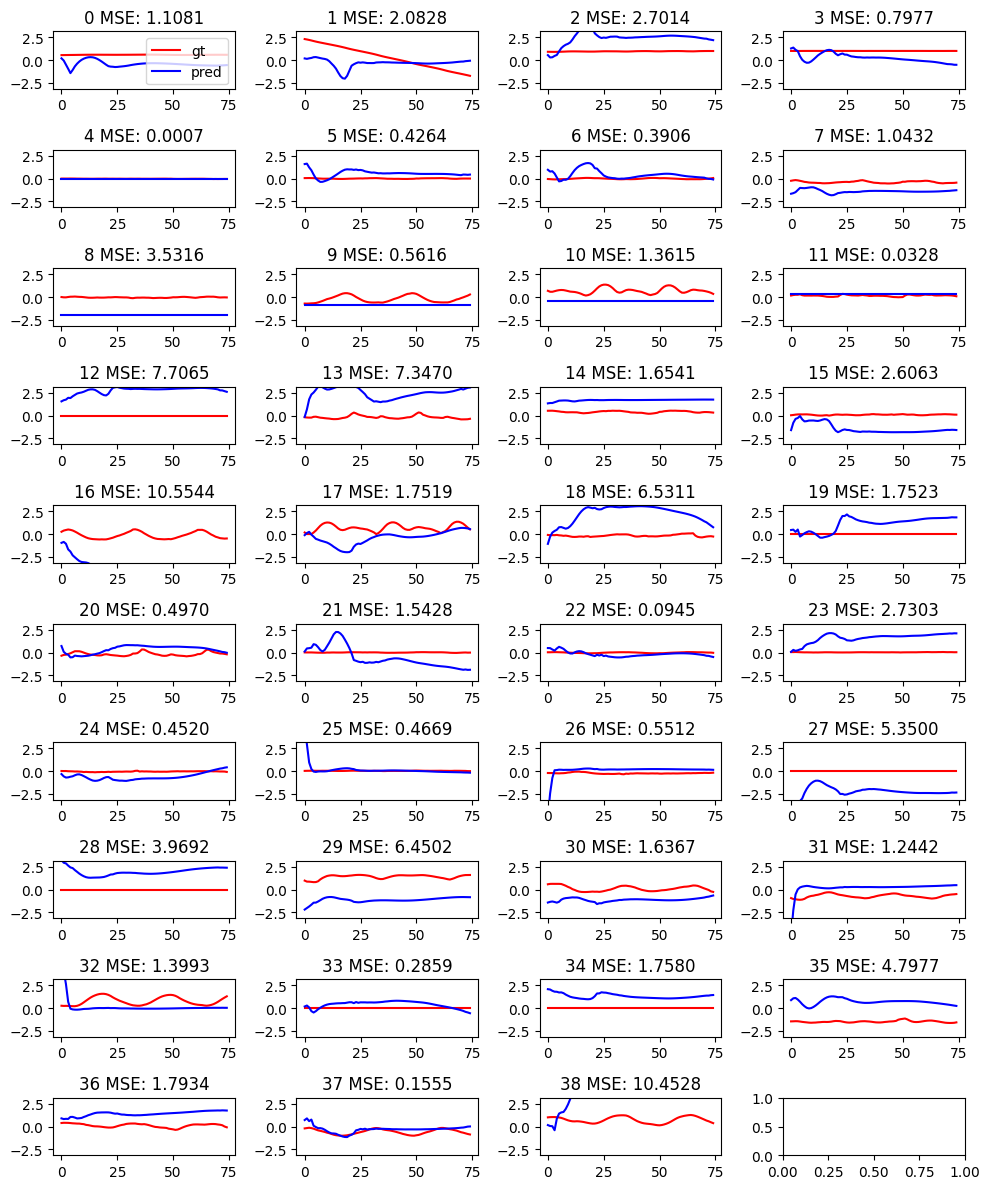

In [ ]:

for t in range(75): 
    
    epos = env.get_expert_attr('qpos', env.get_expert_index(t)).copy()
    # print(epos.shape)
    if env.expert['meta']['cyclic']:
        init_pos = env.expert['init_pos']
        cycle_h = env.expert['cycle_relheading'] # relative heading quaternion
        cycle_pos = env.expert['cycle_pos']
        epos[:3] = quat_mul_vec(cycle_h, epos[:3] - init_pos) + cycle_pos 
        epos[3:7] = quaternion_multiply(cycle_h, epos[3:7])
    poses['gt'].append(epos) 
    poses['pred'].append(env_f.data.qpos.copy())
    action = policy_net.select_action(state_var, mean_action=True)[0].cpu().numpy()
    print(t, state.shape, action.shape)
    next_state, reward, done = env_f.step(action)
    # print(np.std(next_state_f))
    if running_state is not None:
        next_state = running_state(next_state, update=False)
    if done:
        # print(f"fail: {info['fail']}")
        break
    state = next_state
    # print("np.std(state) vs ",np.std(state), np.std(epos))

poses['gt'] = np.vstack(poses['gt'])
poses['pred'] = np.vstack(poses['pred'])
plot_pose = True
if plot_pose:
    # import matplotlib.pyplot as plt
    fig, axs = plt.subplots(nrows=poses['gt'].shape[1]//4+1, ncols=4, figsize=(10, 12))
    for i in range(poses['gt'].shape[1]//4+1):
        for j in range(4):
            if i*4 + j < poses['gt'].shape[1]:
                gt = poses['gt'][:, i*4 + j]
                pred = poses['pred'][:, i*4 + j]
                mse = np.mean((gt - pred) ** 2)
                axs[i, j].plot(gt, 'r', label='gt')
                axs[i, j].plot(pred, 'b', label='pred')
                axs[i, j].set_ylim([-np.pi, np.pi])
                axs[i, j].set_title(f'{i*4 + j} MSE: {mse:.4f}')
            if i == 0 and j == 0:
                axs[i, j].legend()
    plt.tight_layout()
    plt.show()
    



In [6]:
qpos = env.expert['qpos']
qpos.shape

(75, 39)

In [7]:
# interpolate each joint
import numpy as np
from scipy.interpolate import interp1d
qpos = env.expert['qpos']
qpos.shape
qpos_interp = interp1d(np.arange(qpos.shape[0]), qpos, axis=0, kind='cubic')
qpos_interp = qpos_interp(np.linspace(0, qpos.shape[0]-1, 1000))
# plot_qpos(qpos_interp)

In [8]:
sim.data.qpos.shape

NameError: name 'sim' is not defined

In [ ]:
model_file = f'khrylib/assets/mujoco_models/mocap_v2_freeze.xml'
model = load_model_from_path(model_file)
sim = MjSim(model)
body_qposaddr = get_body_qposaddr(model)
body_qposaddr
res = sim.render(255, 255)
# res

array([[[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       [[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       [[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       ...,

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]],

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]],

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]]